In [1]:
import numpy as np
import skimage as sk
import skimage.io as skio
import skimage.filters as skfil
import skimage.transform as sktr
import cv2
from skimage import color
from skimage.color import rgb2gray
from skimage import feature
from scipy.signal import unit_impulse, convolve2d
from scipy.ndimage import rotate
from align_image_code import align_images
import matplotlib.pyplot as plt

In [537]:
def image_save_res(filepath, image):
    plt.imsave(filepath, np.clip(image * 255, 0, 255).astype(np.uint8))
    
def gradientMagnitude(dx, dy):
    return np.sqrt(dx**2 + dy**2)

def gaussianFilter2D(size, sigma):
    gaussKern = cv2.getGaussianKernel(size, sigma)
    gaussFilter = gaussKern @ gaussKern.T #sizexsize kernel, sigma = sigma
    return gaussFilter

def convolveColor(img, filt):
    c0 = convolve2d(img[:,:,0], filt, mode='same')
    c1 = convolve2d(img[:,:,1], filt, mode='same')
    c2 = convolve2d(img[:,:,2], filt, mode='same')
    res = np.dstack([c0, c1, c2])
    return res

def rescale(im):
    return (im-np.min(im))/(np.max(im)-np.min(im))

# **Part 1.1**

In [2]:
dx = np.array([[1, -1]])
dy = np.array([[1], [-1]])

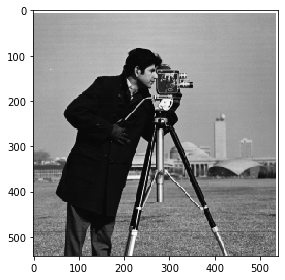

In [3]:
imname = "cameraman.png"
im_gray = skio.imread(imname, as_gray=True)

# convert to double (might want to do this later on to save memory)    
im_gray = sk.img_as_float(im_gray)

skio.imshow(im_gray)

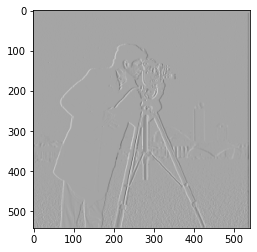

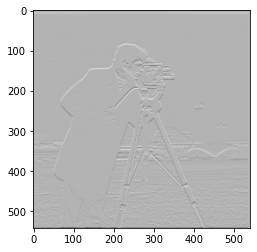

In [4]:
# convolve(im, dx)

convy = convolve2d(im_gray, dy, mode="same")
convx = convolve2d(im_gray, dx, mode="same")
plt.imshow(convx, cmap='Greys')
plt.show()
plt.imshow(convy, cmap='Greys')
plt.show()

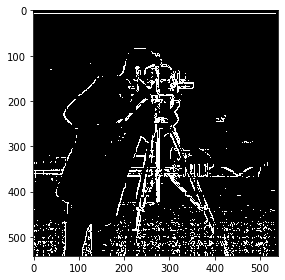

In [5]:
threshold = .1
gradmagdxdy = gradientMagnitude(convx,convy) >= threshold

skio.imshow(gradmagdxdy)
plt.show()

# **Part 1.2**

In [6]:
gaussFilter = gaussianFilter2D(5, 2.5)

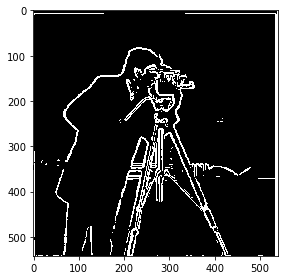

In [7]:
# d/dx (g * f)
threshold = .07
convGauss = convolve2d(im_gray, gaussFilter, mode="same")
convGaussDx = convolve2d(convGauss, dx, mode="same")
convGaussDy = convolve2d(convGauss, dy, mode="same")
skio.imshow(gradientMagnitude(convGaussDx, convGaussDy) >= threshold)
plt.show()

There is significantly less noise with using the gaussian threshold and the difference operators, than just the difference operators.

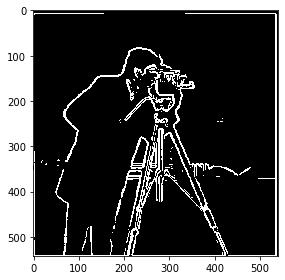

In [8]:

# first differentiate image then apply filter
# should be same as apply filter on image then differentiating each
# (d/dx g) * f
convyGauss = convolve2d(convx, gaussFilter, mode="same")
convxGauss = convolve2d(convy, gaussFilter, mode="same")
skio.imshow(gradientMagnitude(convxGauss,convyGauss) >= threshold)
plt.show()

The resulting images are the same.

# **Part 1.3**

In [9]:
# scipy.ndimage.interpolation.rotate
facade = skio.imread('facade.jpg', as_gray=True)
facade = sk.img_as_float(facade)

In [350]:

def compute_dx_dy(img):
    dx = np.array([[1, -1]])
    dy = np.array([[1], [-1]])
    img_dx = convolve2d(img, dx, mode="same")
    img_dy = convolve2d(img, dy, mode="same")
    return img_dx, img_dy

def compute_gauss(img):
    gaussKern = cv2.getGaussianKernel(15, 3)
    gaussFilter = gaussKern @ gaussKern.T
    return convolve2d(img, gaussFilter, mode="same")

def gradientAngle(dx, dy):
    res = np.arctan2(dy, dx)
    return np.degrees(res)

In [351]:
def auto_straighten(image, crop, start, end):
    degrees = np.arange(start, end, 1)
    bins = np.arange(-180, 181, 3)
    good_bins = [0, 29, 30, 59, 60, 89, 90, 119, -1]
    best_ratio, best_degree, best_hist = 0, 0, []
    resbin = 0
    for degree in degrees:
        rotated = rotate(image, degree, reshape=False,order=1)[crop:-crop, crop: -crop]
        img_dx, img_dy = compute_dx_dy(rotated)
        img_gauss_dx, img_gauss_dy = compute_gauss(img_dx), compute_gauss(img_dy)
        gradAngle = gradientAngle(img_gauss_dx, img_gauss_dy).flatten()
        histogram, resbin = np.histogram(gradAngle, bins=bins)
        ratio = sum([histogram[i] for i in good_bins])/sum(histogram)
        if ratio > best_ratio:
            best_ratio = ratio
            best_degree = degree
            best_hist = histogram
    return best_degree, best_hist

def straightening_procedure(image_name, crop=300, start=-10, end=10):
    img = skio.imread(image_name, as_gray=True)
    img_color = skio.imread(image_name)
    img = sk.img_as_float(img)
    img_color = sk.img_as_float(img_color)
    deg, hist = auto_straighten(img, crop, start, end)
    bins = np.arange(-180, 181, 3)
    f = plt.figure(figsize=(15, 5))
    f.add_subplot(1, 3, 1)
    skio.imshow(img_color)
    f.add_subplot(1,3, 2)
    skio.imshow(rotate(img_color, deg, order=1))
    f.add_subplot(1,3, 3)
    plt.bar(x=bins[:-1], height=hist, width=10)
    f.tight_layout()
    plt.title("Histogram of Gradient Angles, Degree " + str(deg) + " rotation")
    plt.show(block=True)


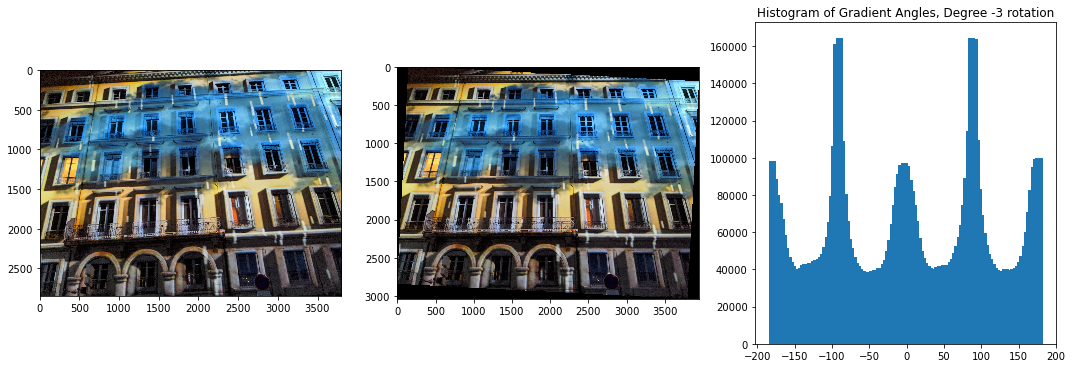

In [352]:
straightening_procedure('facade.jpg', start=-7, end=7)

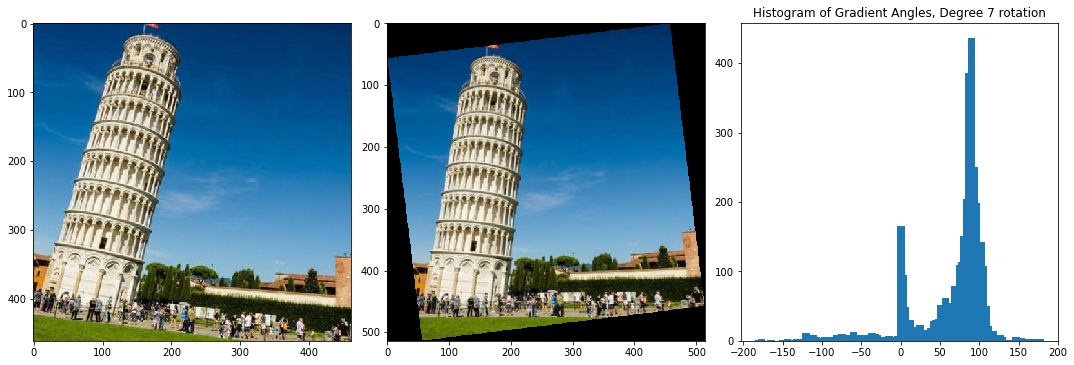

In [353]:
straightening_procedure('piza.jpeg', crop=200, start=0, end=12)

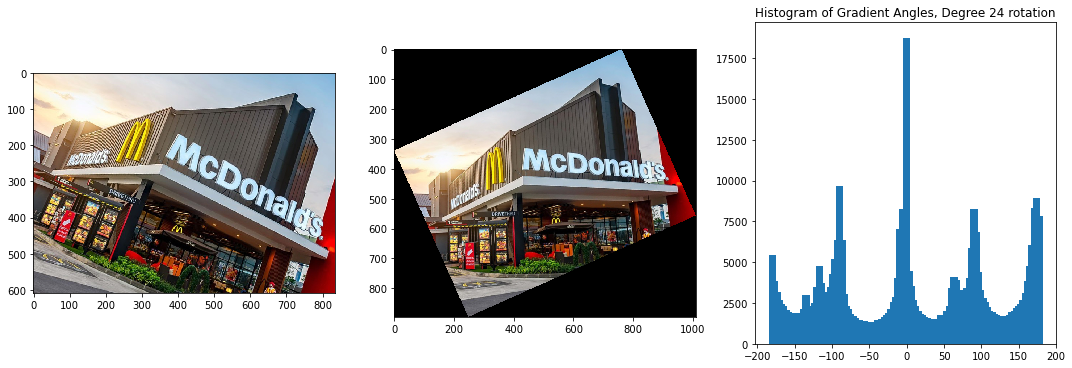

In [354]:
straightening_procedure('mcdonalds.jpg', start=0, end=25, crop=50)

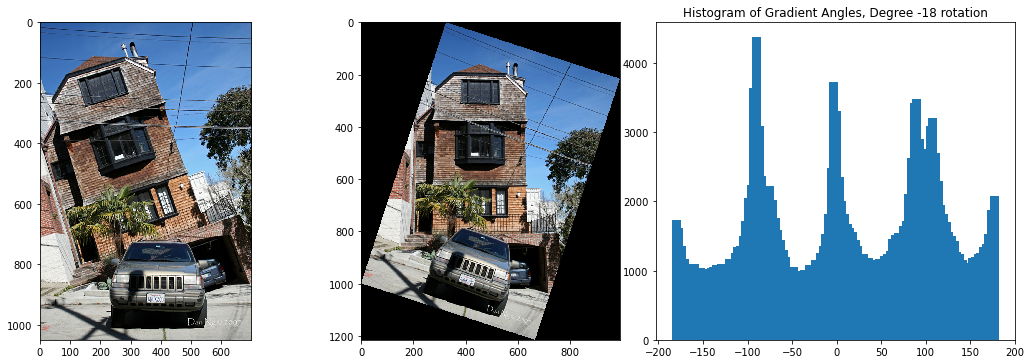

In [355]:
straightening_procedure('house.jpg', start=-20, end=0, crop=200)

# **Part 2.1**

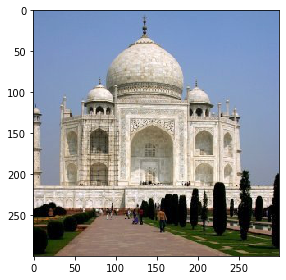

In [16]:
taj = skio.imread('taj.jpg')
taj = sk.img_as_float(taj)
skio.imshow(taj)

In [356]:
gaussFilter = gaussianFilter2D(5, 1)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


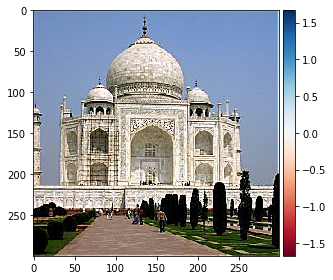

In [18]:
# operation:  f * ((1+alpha)(unit_impulse) - alpha x filter)
alpha = 2
unit_imp = unit_impulse(gaussFilter.shape, idx="mid")
unsharp_filt = (1+alpha)*(unit_imp) - alpha*gaussFilter #alpha = 2
taj_sharpened = convolveColor(taj, unsharp_filt)
skio.imshow(taj_sharpened)

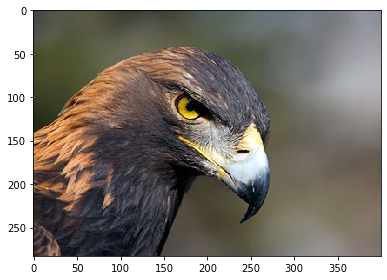

In [19]:
sharp_img = skio.imread('sharp.jpg')
sharp_img = sk.img_as_float(sharp_img)
skio.imshow(sharp_img)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


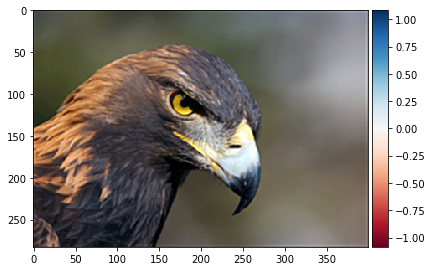

In [20]:
alpha = 2
blurred_sharp_img = convolveColor(sharp_img, gaussFilter)
unsharp_filt = (1+alpha)*(unit_imp) - alpha*gaussFilter #alpha = 2
sharper_img = convolveColor(blurred_sharp_img, unsharp_filt)
skio.imshow(sharper_img)

Image appears to be slightly less sharp than the original image, after we sharpen the blurred image.

# **Part 2.2**

In [33]:
# First load images


# high sf
im1 = skio.imread('./DerekPicture.jpg')
im1 = sk.img_as_float(im1)
# low sf
im2 = skio.imread('./nutmeg.jpg')
im2 = sk.img_as_float(im2)

%matplotlib qt
# Next align images (this code is provided, but may be improved)
im2_aligned, im1_aligned = align_images(im2, im1)

Please select 2 points in each image for alignment.


In [77]:
## You will provide the code below. Sigma1 and sigma2 are arbitrary 
## cutoff values for the high and low frequencies
%matplotlib inline

def hybrid_image(im1, im2, sigma1, sigma2, size1=30, size2=50, color=True):
    gauss1 = gaussianFilter2D(size1, sigma1)
    gauss2 = gaussianFilter2D(size2, sigma2)
    if not color:
        lowpass = convolve2d(rgb2gray(im1), gauss1, mode="same")
        highpass = rgb2gray(im2) - convolve2d(rgb2gray(im2), gauss2, mode="same")
        return lowpass + highpass
    lowpass = convolveColor(im1, gauss1)
    highpass = im2 - convolveColor(im2, gauss2)
    return lowpass + highpass, lowpass, highpass
# plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


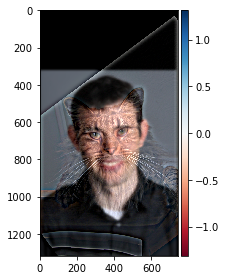

In [505]:
sigma1 = 5
sigma2 = 15
hybrid, lowpass, highpass = hybrid_image(im1_aligned, im2_aligned, sigma1, sigma2, color=True)
skio.imshow(hybrid)

In [532]:
# image_save_res('./res/catman.jpg', hybrid[350:])

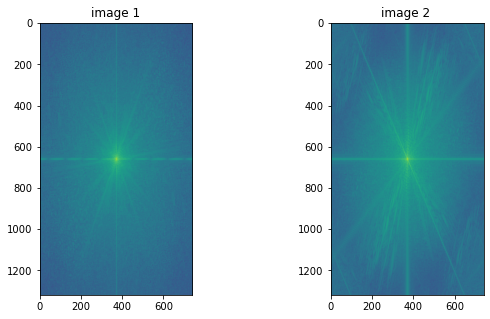

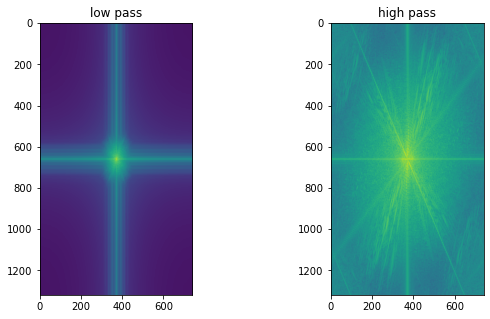

In [51]:
f = plt.figure(figsize=(20, 5))
f.add_subplot(1, 4, 1)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(im1_aligned))))))
plt.title("image 1")
f.add_subplot(1, 4, 2)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(im2_aligned))))))
plt.title("image 2 ")
plt.show()
f = plt.figure(figsize=(20, 5))
f.add_subplot(1, 4, 1)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(lowpass))))))
plt.title("low pass")
f.add_subplot(1, 4, 2)
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(highpass))))))
plt.title("high pass")
plt.show()

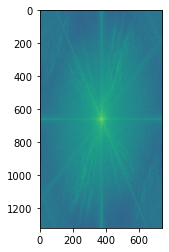

In [37]:
plt.imshow(np.log(np.abs(np.fft.fftshift(np.fft.fft2(rgb2gray(hybrid))))))
plt.show()

In [61]:
# high sf
im3 = skio.imread('./ddcat.jpg')
im3 = sk.img_as_float(im3)
# low sf
im4 = skio.imread('./bread.jpg')
im4 = sk.img_as_float(im4)

%matplotlib qt
# Next align images (this code is provided, but may be improved)
im4_aligned, im3_aligned = align_images(im4, im3)

Please select 2 points in each image for alignment.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


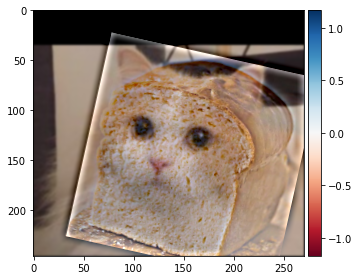

In [211]:
sigma3 = 1
sigma4 = 5
hybrid_dd, lowpass_dd, highpass_dd = hybrid_image(im3_aligned, im4_aligned, sigma3, sigma4, size1=15, size2=15,color=True)
skio.imshow(hybrid_dd)

In [534]:
# image_save_res("res/hybrid_dd.jpg", hybrid_dd[30:])

In [235]:
# high sf
im5 = sk.img_as_float(skio.imread('./trump.jpg'))
# low sf
im6 = sk.img_as_float(skio.imread('./kim.jpg'))

%matplotlib qt
# Next align images (this code is provided, but may be improved)
im6_aligned, im5_aligned = align_images(im6, im5)

Please select 2 points in each image for alignment.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


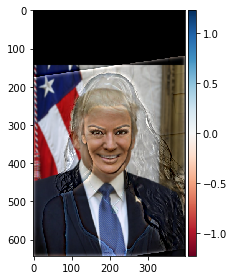

In [245]:
%matplotlib inline
sigma5 = 1
sigma6 = 5
hybrid_trump, lowpass_trump, highpass_trump = hybrid_image(im5_aligned, \
                                                           im6_aligned, sigma5, sigma6, size1=5, size2=30,color=True)
skio.imshow(hybrid_trump)

In [538]:
# image_save_res("./res/kardashitrump.jpg", rescale(hybrid_trump[140:]))

# Part 2.3

In [376]:
def gaussian_stack(im, size, sigma, layers, color):
    stack = [im if color else rgb2gray(im)]
    for i in range(layers):
        if not color:
            stack.append(convolve2d(stack[i], gaussianFilter2D(size, sigma), mode="same"))
        else:
            stack.append(convolveColor(stack[i], gaussianFilter2D(size, sigma)))
    return stack

def laplacian_stack(im, size, sigma, layers, color):
    gauss_stack = gaussian_stack(im, size, sigma, layers, color=color)
    stack = []
    for i in range(len(gauss_stack)-1):
        stack.append(gauss_stack[i+1] - gauss_stack[i])
    stack.append(gauss_stack[-1])
    return stack


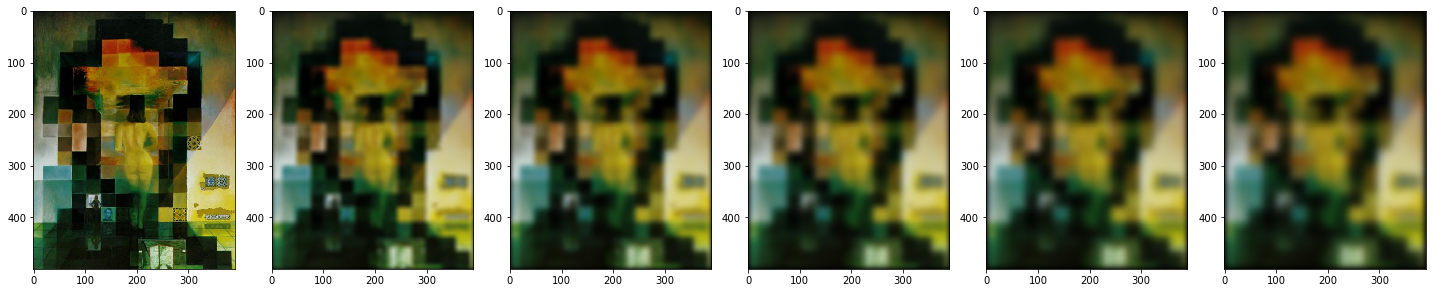

In [200]:
lincoln = skio.imread("./lincoln.jpg")
lincoln = sk.img_as_float(lincoln)
lincoln_gauss_stack = gaussian_stack(lincoln, 15, 5, 5, True)
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(lincoln_gauss_stack, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(val)
plt.show()
# f.savefig('./res/lincoln_gauss_stack.jpg')

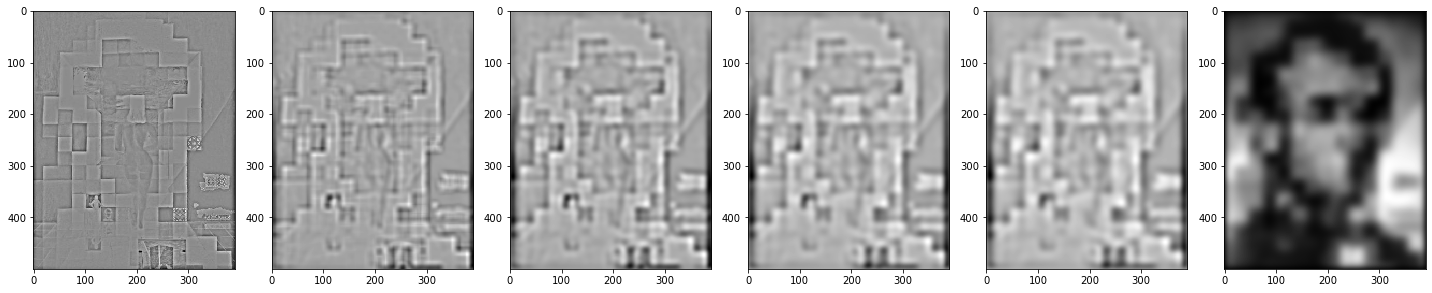

In [365]:
lincoln_laplace_stack = laplacian_stack(lincoln, 15, 5, 5, False)
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(lincoln_laplace_stack, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()
# f.savefig('./res/lincoln_laplace_stack.jpg')

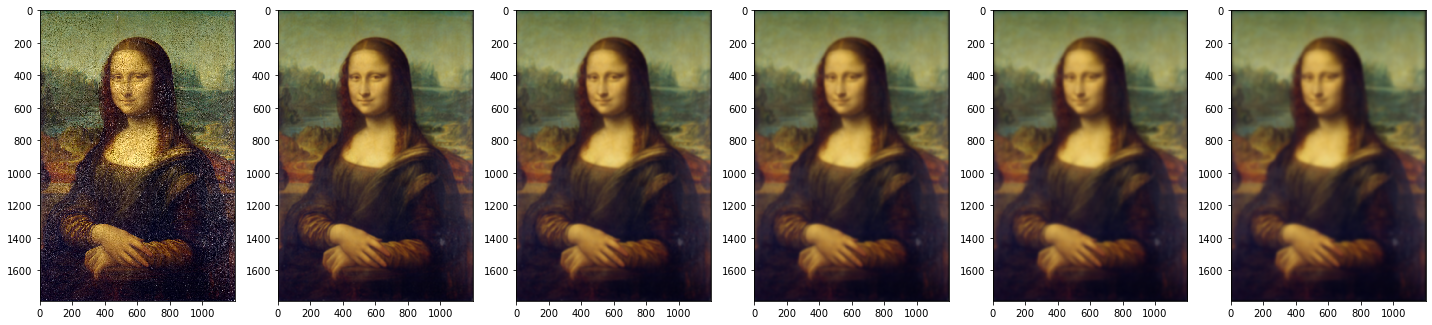

In [203]:
mona = skio.imread("./mona.jpg")
mona = sk.img_as_float(mona)
mona_gauss_stack = gaussian_stack(mona, 15, 5, 5, True)
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(mona_gauss_stack, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(val)
plt.show()
# f.savefig('./res/mona_gauss_stack.jpg')

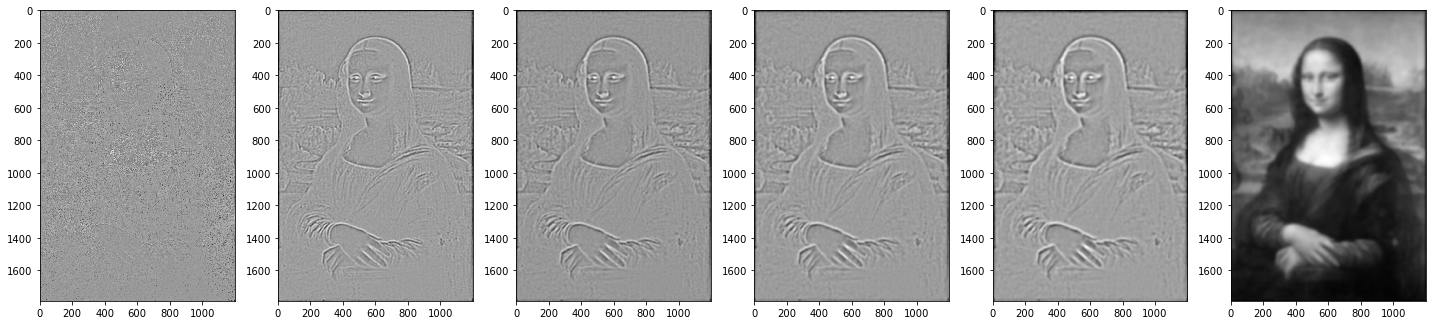

In [366]:
mona_laplace_stack = laplacian_stack(mona, 15, 5, 5, False)
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(mona_laplace_stack, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()
# f.savefig('./res/mona_laplace_stack.jpg')

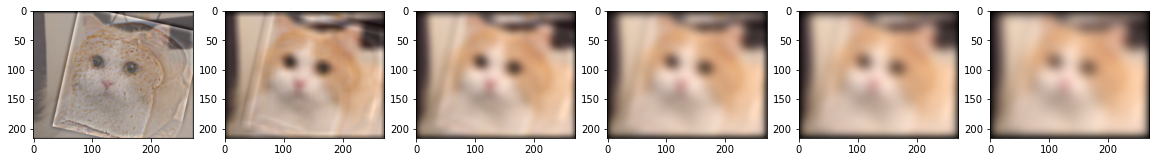

In [207]:
hybrid_gauss_stack = gaussian_stack(hybrid_dd[30:], 15, 8, 5, True)
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(hybrid_gauss_stack, 1):
    f.add_subplot(1, 6, i)
    plt.imshow(rescale(val))
plt.show()
# f.savefig('res/dd_gauss_stack.jpg')

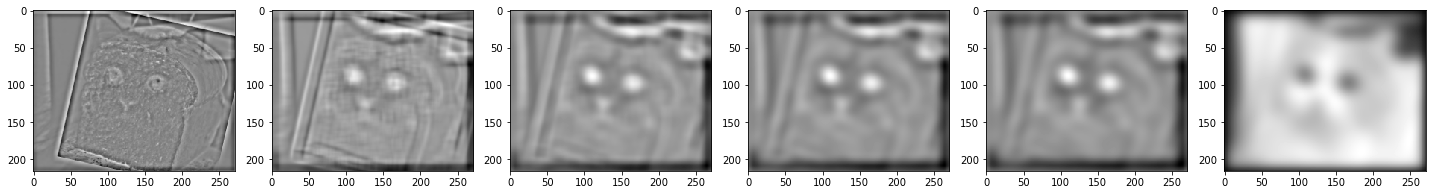

In [367]:
dd_laplace_stack = laplacian_stack(hybrid_dd[30:], 15, 8, 5, False)
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(dd_laplace_stack, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()
# f.savefig('res/dd_laplace_stack.jpg')

# 2.4

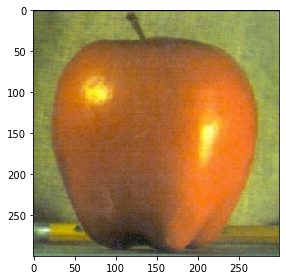

In [292]:
apple = sk.img_as_float(skio.imread("apple.jpeg"))
orange = sk.img_as_float(skio.imread("orange.jpeg"))
skio.imshow(apple)

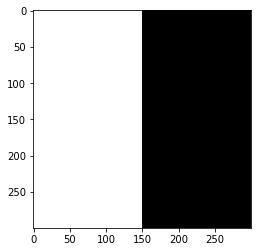

In [337]:
half_mask = np.zeros((300,300, 3))
half_mask[:, :150] = 1
plt.imshow(half_mask)

In [528]:
def blend_image(im1, im2, mask, size, sigma, masksize, masksigma, layers):
    la = laplacian_stack(im1, size, sigma, layers, True)
    lb = laplacian_stack(im2, size, sigma, layers, True)
    gr = gaussian_stack(mask, masksize, masksigma, layers, True) #mask
    ls = []
    for i in range(len(la)):
        ls.append(gr[i]*la[i] + (1-gr[i])*lb[i])
    collapse_ls = np.sum(ls, axis=0)
    return collapse_ls

def blend_image_test(im1, im2, mask, size, sigma, masksize, masksigma, layers):
    la = laplacian_stack(im1, size, sigma, layers, True)
    lb = laplacian_stack(im2, size, sigma, layers, True)
    gr = gaussian_stack(mask, masksize, masksigma, layers, True) #mask
    left, right = [], []
    for i in range(len(la)):
        left.append(gr[i]*la[i])
        right.append((1-gr[i])*lb[i])
    return left, right

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


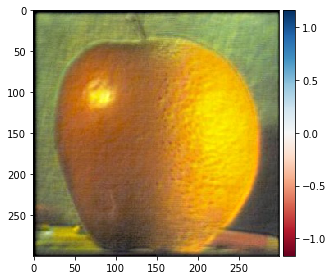

In [380]:
apporange = blend_image(apple, orange, half_mask, 30, 1, 50, 15, 5)
skio.imshow(apporange)

In [529]:
# image_save_res("res/apporange.jpg", apporange)

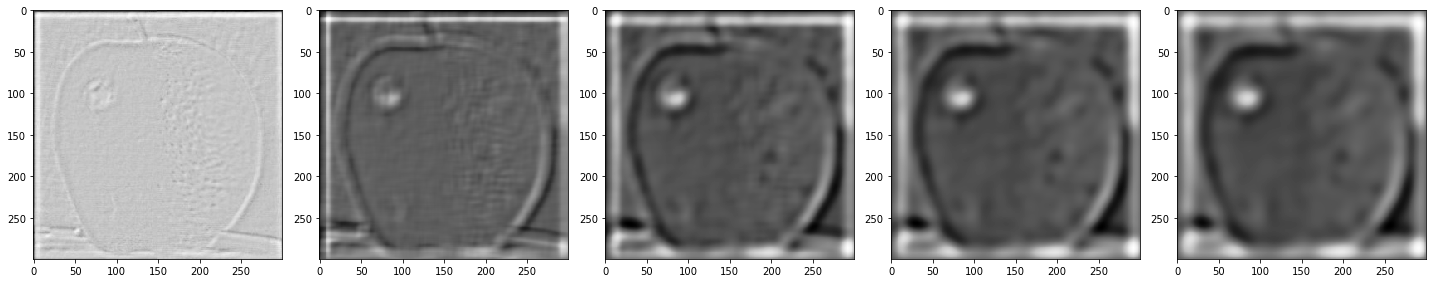

In [417]:
blend_laplace_stack = laplacian_stack(apporange, 15, 8, 5, False)[:-1]
f = plt.figure(figsize=(20, 5))
for i, val in enumerate(blend_laplace_stack, 1):
    f.add_subplot(1, 5, i)
    skio.imshow(rescale(val), cmap='Greys')
plt.show()

In [398]:
testleft, testright = blend_image_test(apple, orange, half_mask, 30, 1, 50, 15, 5)

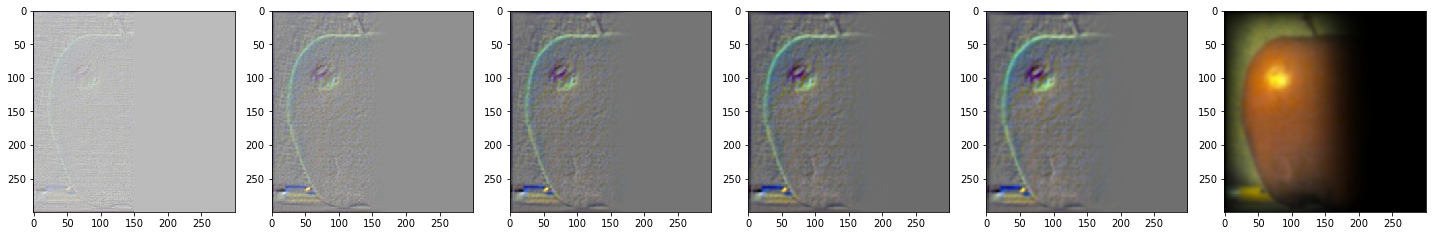

In [413]:
f = plt.figure(figsize=(20, 15))
for i, val in enumerate(testleft, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()

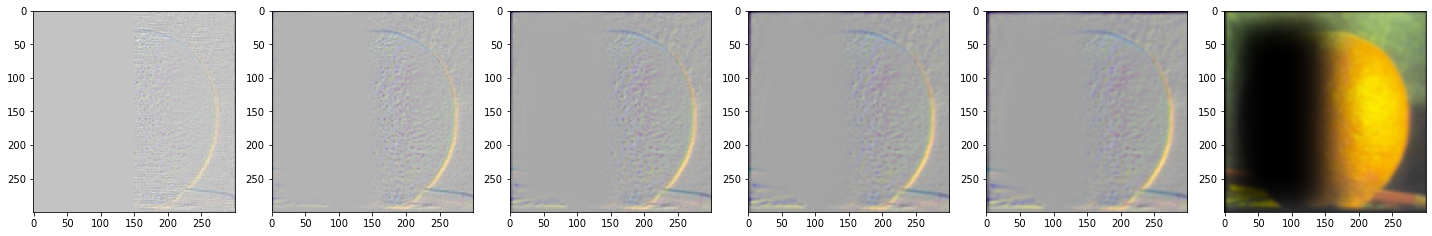

In [420]:
f = plt.figure(figsize=(20, 15))
for i, val in enumerate(testright, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()

(743, 800, 3) (743, 800, 3) (743, 800, 3)


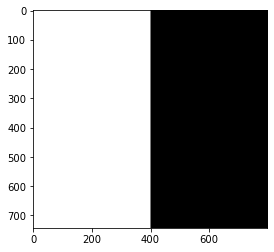

In [559]:
sun_mask = np.zeros((743, 800, 3))
sun_mask[:, :400] = 1
sun = sk.img_as_float(skio.imread("sun.jpg"))
moon = sk.img_as_float(skio.imread("moon.jpg"))
print(moon.shape, sun.shape, sun_mask.shape)
plt.imshow(sun_mask)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


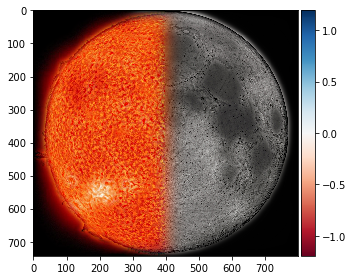

In [584]:
sunmoon = blend_image(sun, moon, sun_mask, 15, 3, 30, 15, 8)
skio.imshow(sunmoon)

In [587]:
# image_save_res('./res/sunmoon.jpg', sunmoon)
# image_save_res('./res/moonsun.jpg', sunmoon)

In [540]:
doggy = sk.img_as_float(skio.imread("bridge.jpg"))
cheetah = sk.img_as_float(skio.imread("borealis.jpg"))
doggymask = sk.img_as_float(skio.imread("bridgemask2.jpg"))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


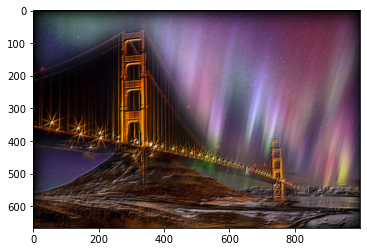

In [541]:
# takes a while to run
doggetah = blend_image(cheetah, doggy, doggymask, 30, 1, 50, 25, 5)
plt.imshow(doggetah)

In [542]:

# image_save_res("./res/bridge_aurora2.jpg",doggetah)

In [546]:
testleft2, testright2 = blend_image_test(doggy, cheetah, doggymask, 30, 1, 50, 25, 5)

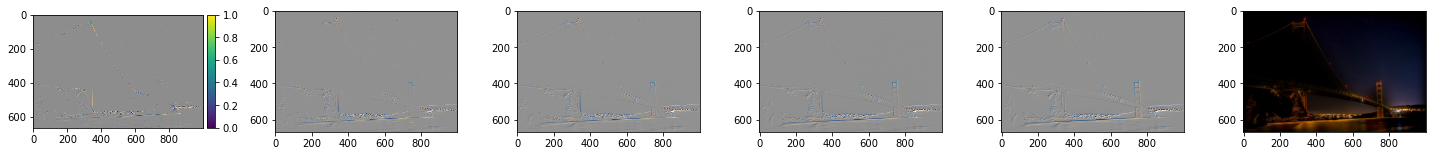

In [547]:
f = plt.figure(figsize=(20, 3))
for i, val in enumerate(testleft2, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()
# f.savefig('res/bridge_left2.jpg')

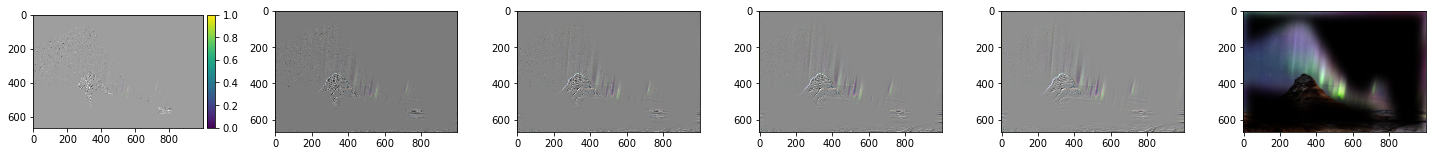

In [548]:
f = plt.figure(figsize=(20, 3))
for i, val in enumerate(testright2, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val))
plt.show()
# f.savefig('res/bridge_right2.jpg')

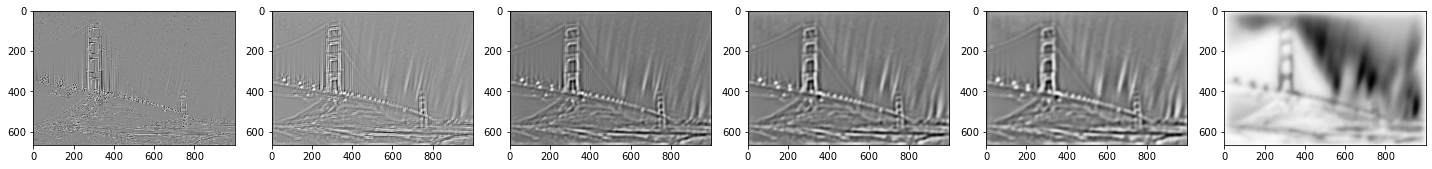

In [549]:
blend_laplace_stack2 = laplacian_stack(doggetah, 15, 8, 5, False)
f = plt.figure(figsize=(20, 3))
for i, val in enumerate(blend_laplace_stack2, 1):
    f.add_subplot(1, 6, i)
    skio.imshow(rescale(val), cmap='Greys')
plt.show()
# f.savefig('res/bridge_stack2.jpg')